# Naïve Bayes Classifier

1. Import libraries - pandas, sklearn.
2. Read the dataset.
3. Split the dataset into train and test.
4. Train the model using training data.
5. Test the model using test data.
6. Evaluate the model.

Dataset used : https://www.kaggle.com/pablomgomez21/drugs-a-b-c-x-y-for-decision-trees

In [15]:
# preprocessing
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

# model imports
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# deployment libraries
import onnxruntime as rt
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx

In [2]:
drugs_dataset = pd.read_csv('../../.resources/data/drug200.csv')
drugs_dataset

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [3]:
drugs_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


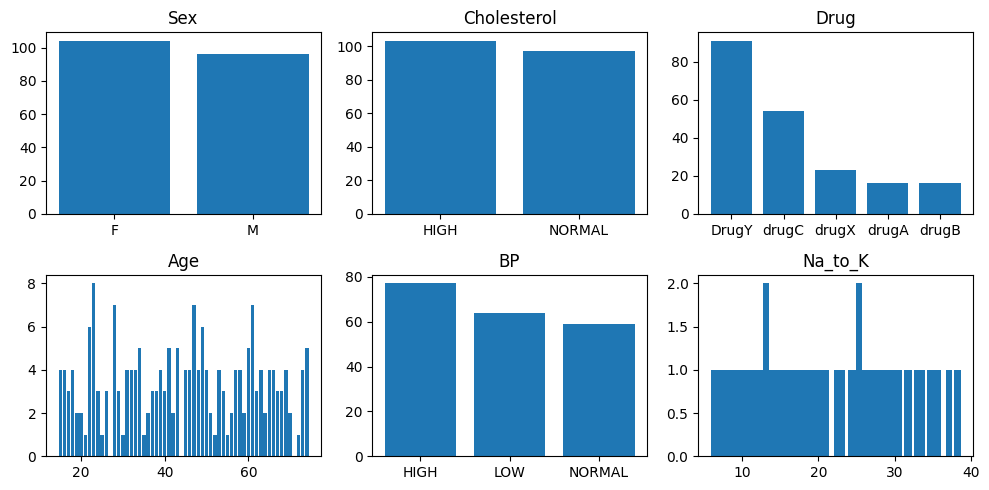

In [4]:
columns = drugs_dataset.columns
fig, ax = plt.subplots(len(columns)//3, 3, figsize=(10, 5))
for i in range(len(columns)):
    col = columns[i]
    if i%2 != 0:
        ax[0, i//2].bar(drugs_dataset[col].unique(), drugs_dataset[col].value_counts())
        ax[0, i//2].set_title(col)
    else:
        ax[1, i//2].bar(drugs_dataset[col].unique(), drugs_dataset[col].value_counts())
        ax[1, i//2].set_title(col)
plt.tight_layout()

In [5]:
changed_labels = []

changed_labels.append(pd.factorize(drugs_dataset['Sex'])[1])
drugs_dataset['Sex'] = pd.factorize(drugs_dataset['Sex'])[0]

changed_labels.append(pd.factorize(drugs_dataset['BP'])[1])
drugs_dataset['BP'] = pd.factorize(drugs_dataset['BP'])[0]

changed_labels.append(pd.factorize(drugs_dataset['Cholesterol'])[1])
drugs_dataset['Cholesterol'] = pd.factorize(drugs_dataset['Cholesterol'])[0]

changed_labels.append(pd.factorize(drugs_dataset['Drug'])[1])
drugs_dataset['Drug'] = pd.factorize(drugs_dataset['Drug'])[0]

print(changed_labels)
drugs_dataset

[Index(['F', 'M'], dtype='object'), Index(['HIGH', 'LOW', 'NORMAL'], dtype='object'), Index(['HIGH', 'NORMAL'], dtype='object'), Index(['DrugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype='object')]


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
1,47,1,1,0,13.093,1
2,47,1,1,0,10.114,1
3,28,0,2,0,7.798,2
4,61,0,1,0,18.043,0
...,...,...,...,...,...,...
195,56,0,1,0,11.567,1
196,16,1,1,0,12.006,1
197,52,1,2,0,9.894,2
198,23,1,2,1,14.020,2


In [6]:
x = drugs_dataset.drop(columns='Drug').to_numpy()
x

array([[23.   ,  0.   ,  0.   ,  0.   , 25.355],
       [47.   ,  1.   ,  1.   ,  0.   , 13.093],
       [47.   ,  1.   ,  1.   ,  0.   , 10.114],
       [28.   ,  0.   ,  2.   ,  0.   ,  7.798],
       [61.   ,  0.   ,  1.   ,  0.   , 18.043],
       [22.   ,  0.   ,  2.   ,  0.   ,  8.607],
       [49.   ,  0.   ,  2.   ,  0.   , 16.275],
       [41.   ,  1.   ,  1.   ,  0.   , 11.037],
       [60.   ,  1.   ,  2.   ,  0.   , 15.171],
       [43.   ,  1.   ,  1.   ,  1.   , 19.368],
       [47.   ,  0.   ,  1.   ,  0.   , 11.767],
       [34.   ,  0.   ,  0.   ,  1.   , 19.199],
       [43.   ,  1.   ,  1.   ,  0.   , 15.376],
       [74.   ,  0.   ,  1.   ,  0.   , 20.942],
       [50.   ,  0.   ,  2.   ,  0.   , 12.703],
       [16.   ,  0.   ,  0.   ,  1.   , 15.516],
       [69.   ,  1.   ,  1.   ,  1.   , 11.455],
       [43.   ,  1.   ,  0.   ,  0.   , 13.972],
       [23.   ,  1.   ,  1.   ,  0.   ,  7.298],
       [32.   ,  0.   ,  0.   ,  1.   , 25.974],
       [57.   ,  1. 

In [7]:
y = drugs_dataset['Drug'].to_numpy()
y

array([0, 1, 1, 2, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 3, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 4, 2, 0, 2, 2, 3, 2, 2, 2, 0, 4, 0, 2,
       2, 2, 3, 1, 0, 0, 0, 2, 0, 0, 4, 1, 4, 0, 2, 0, 0, 3, 0, 2, 4, 0,
       3, 2, 0, 0, 4, 0, 2, 0, 0, 0, 3, 0, 3, 2, 4, 2, 1, 3, 1, 4, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 3, 1, 2, 0, 2, 2, 0, 4, 0,
       3, 2, 2, 2, 2, 0, 2, 2, 3, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 2, 0, 0,
       2, 0, 0, 2, 4, 3, 4, 2, 3, 0, 4, 0, 3, 2, 2, 3, 2, 1, 3, 4, 2, 2,
       0, 1, 3, 0, 1, 2, 2, 4, 2, 0, 0, 0, 0, 2, 0, 3, 2, 2, 0, 0, 3, 0,
       3, 0, 0, 0, 0, 2, 2, 0, 0, 0, 4, 3, 0, 0, 0, 3, 0, 1, 0, 1, 1, 2,
       2, 2])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print('Train features  :', x_train.shape)
print('Train labels    :', y_train.shape)
print('\nTest features   :', x_test.shape)
print('Test labels     :', y_test.shape)

Train features  : (160, 5)
Train labels    : (160,)

Test features   : (40, 5)
Test labels     : (40,)


## Classifier model

In [9]:
model = GaussianNB().fit(x_train, y_train)

### Evaluation

In [10]:
y_pred = model.predict(x_test)
y_pred.shape, y_test.shape

((40,), (40,))

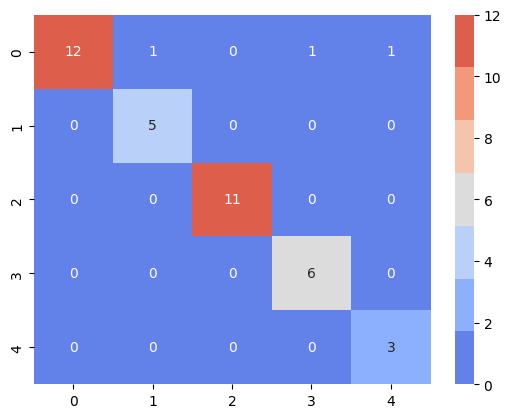

In [11]:
conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt="d", cmap=sns.color_palette("coolwarm", 7))
plt.show()

In [12]:
print('Accurcy of model : %.3f %%' % (model.score(x_test, y_test)*100))
print('\nPrecision score : %.3f %%' % precision_score(y_test, y_pred, average='weighted'))
print('Recall score : %.3f %%' % recall_score(y_test, y_pred, average='weighted'))
print('f1 score : %.3f %%' % f1_score(y_test, y_pred, average='weighted'))

Accurcy of model : 92.500 %

Precision score : 0.939 %
Recall score : 0.925 %
f1 score : 0.925 %


In [17]:
initial_type = [("float_input", FloatTensorType([None, 5]))]
onx = to_onnx(model, x, initial_types=initial_type, options={"zipmap": False})
with open("../../app/onnx_models/naive_bayes.onnx", "wb") as f:
    f.write(onx.SerializeToString())